In [10]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


Final Fidelity (1 - (infidelity + penalty))
0.9580745350486649
Optimized J/V:
0.1, 0.676, 1.153, 1.431, 1.434, 1.113, 0.5
Optimized mu/V:
10.0, 8.257, 6.528, 4.825, 3.161, 1.554, 0.0
Optimized t/V:
0.0, 0.001, 0.002, 0.361, 0.452, 1.04, 2.5


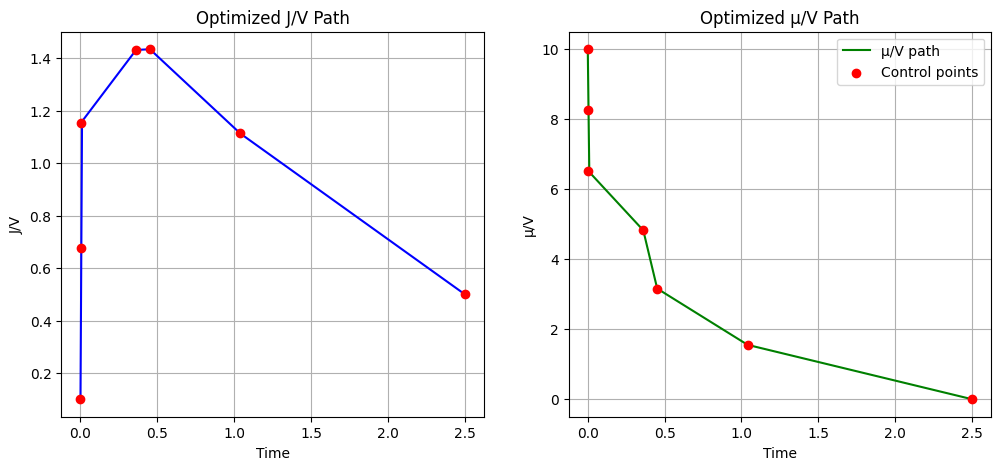

In [11]:
N = 2
M = 3
V = -1
T = 2.5
dt = 0.01

J_V_init = 0.1
J_V_final = 0.5
mu_V_init = 10
mu_V_final = 0

num_free_points = 5
num_control_points = num_free_points + 2  # Intermediate free points + 2 end points

# Run optimization
results = create_optimal_piecewise_linear_paths(N, M, T, dt, V, J_V_init, J_V_final, mu_V_init, mu_V_final, num_control_points, alpha = 2)
(times_dense, J_V_path, mu_V_path, obj_value, opt_params, t_control_opt, J_control_opt, mu_control_opt) = results

print("Final Fidelity (1 - (infidelity + penalty))")
print(1 - obj_value)
print(f"Optimized J/V:")
print(*(np.around(J_control_opt,3)), sep = ", ")
print(f"Optimized mu/V:")
print(*(np.around(mu_control_opt,3)), sep = ", ")
print(f"Optimized t/V:")
print(*(np.around(t_control_opt,3)), sep = ", ")

# --- Plot the optimized paths along with control points ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(times_dense, J_V_path, label="J/V path", color="blue")
plt.scatter(t_control_opt, J_control_opt, color="red", zorder=5, label="Control points")
plt.xlabel("Time")
plt.ylabel("J/V")
plt.title("Optimized J/V Path")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(times_dense, mu_V_path, label="μ/V path", color="green")
plt.scatter(t_control_opt, mu_control_opt, color="red", zorder=5, label="Control points")
plt.xlabel("Time")
plt.ylabel("μ/V")
plt.title("Optimized μ/V Path")
plt.legend()
plt.grid(True)
plt.show()

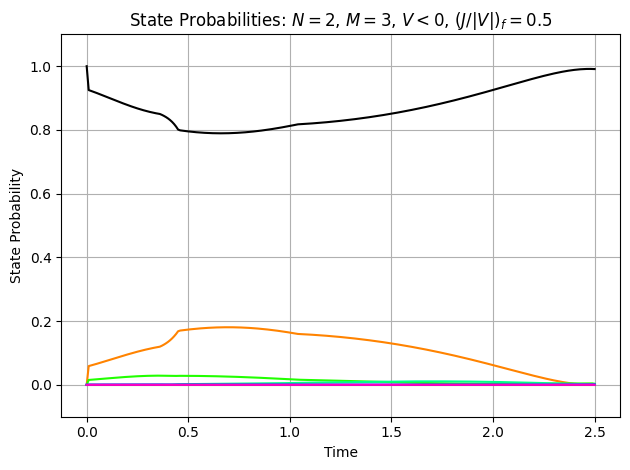

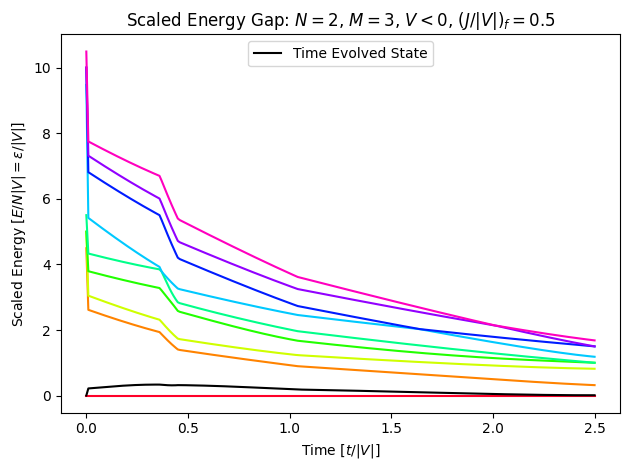

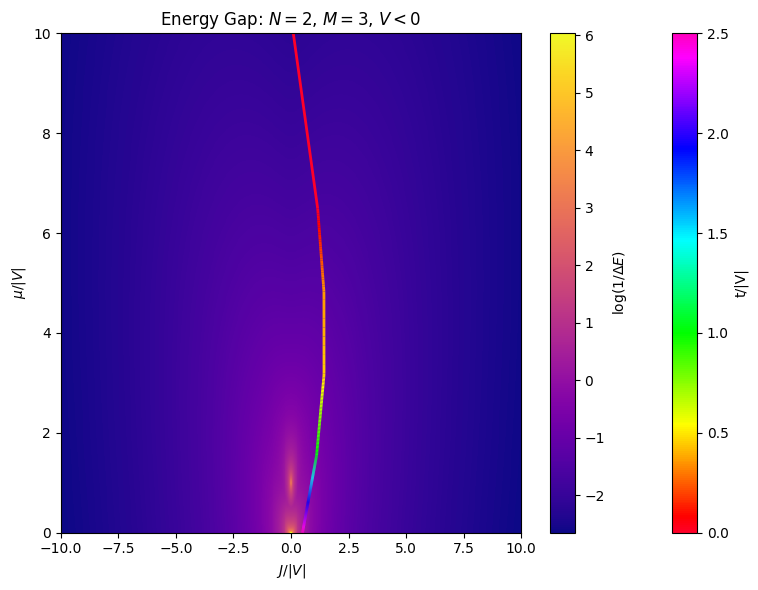

In [12]:
hamiltonians = []
for i, t in enumerate(times_dense):
    ham = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio=mu_V_path[i],J_V_ratio=J_V_path[i])
    hamiltonians.append(ham)

results = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
plot_time_evolution(N, M, results, times_dense, J_V_ratios = J_V_path, mu_V_ratios = mu_V_path, plot_overlaps = False, plot_sigma = False)

if np.sign(V) > 0:
    plot_data(N, M, sign_V="positive", gap_or_sigma="energy_gap", include_path = True, mu_V_ratios = mu_V_path, J_V_ratios = J_V_path, times = times_dense)
else:
    plot_data(N, M, sign_V="negative", gap_or_sigma="energy_gap", include_path = True, mu_V_ratios = mu_V_path, J_V_ratios = J_V_path, times = times_dense)

0.9912363928816464


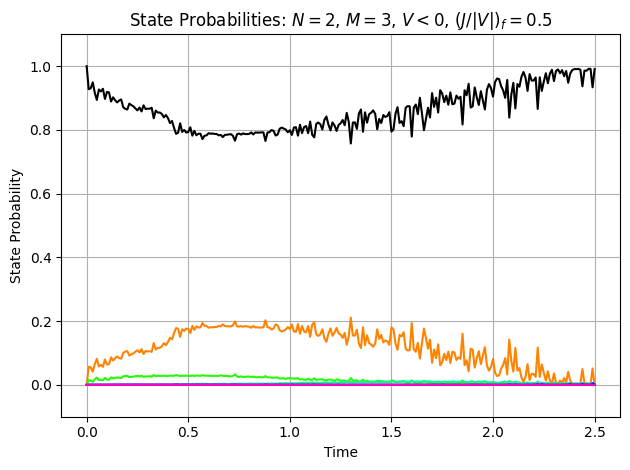

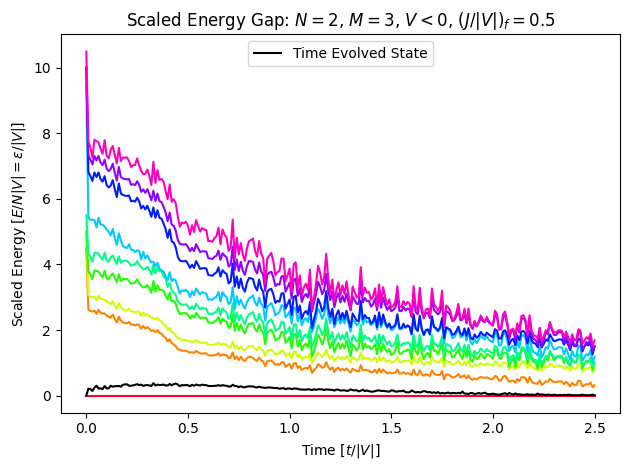

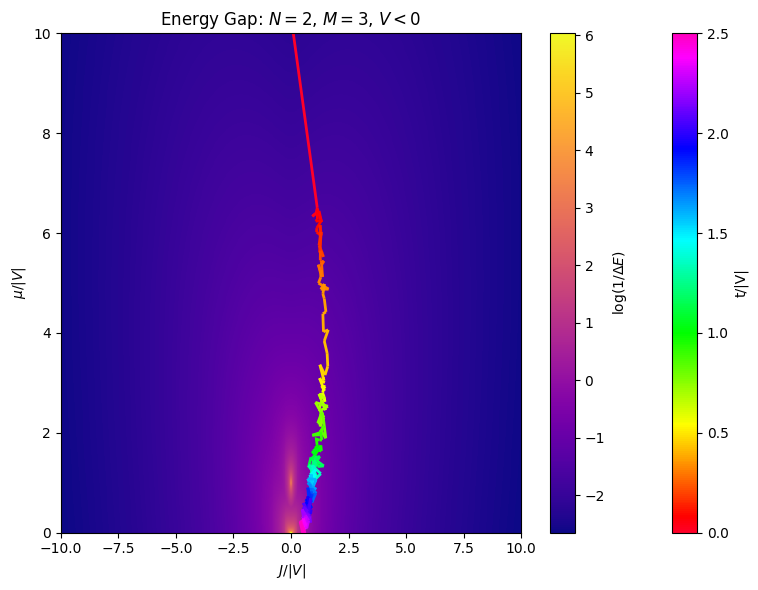

In [13]:
def make_noisy_path(path, noise_strength):
    """
    Adds Gaussian noise to the interior of the given path, leaving the first and last points unchanged.
    """
    noisy_path = path.copy()
    if len(path) > 2:
        noise = np.random.normal(0, noise_strength, size=path[1:-1].shape)
        noisy_path[1:-1] += noise
    return noisy_path

noise_strength = 0.1
J_V_path_noisy = make_noisy_path(J_V_path, noise_strength)
mu_V_path_noisy = make_noisy_path(mu_V_path, noise_strength)

noisy_hamiltonians = []
for i, t in enumerate(times_dense):
    ham = construct_rescaled_hamiltonian(N, M, V,
                                         mu_V_ratio=mu_V_path_noisy[i],
                                         J_V_ratio=J_V_path_noisy[i])
    noisy_hamiltonians.append(ham)

results = simulate_hamiltonian_time_evolution(noisy_hamiltonians, times_dense)
plot_time_evolution(N, M, results, times_dense, J_V_ratios=J_V_path_noisy, mu_V_ratios=mu_V_path_noisy, plot_overlaps = False, plot_sigma = False)


print(results[2][-1][0])

if np.sign(V) > 0:
    plot_data(N, M, sign_V="positive", gap_or_sigma="energy_gap", include_path = True, mu_V_ratios = mu_V_path_noisy, J_V_ratios = J_V_path_noisy, times = times_dense)
else:
    plot_data(N, M, sign_V="negative", gap_or_sigma="energy_gap", include_path = True, mu_V_ratios = mu_V_path_noisy, J_V_ratios = J_V_path_noisy, times = times_dense)